In [4]:
# Let's import the needed packages
# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt
import seaborn as sns

# To plot the map
import cartopy.crs as ccrs

# Importing Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

# One-month prediction of El Nino Events

In [5]:
# Get the data for a 1-month prediction, split and scale the data
X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1. Baseline n°1 - LDA

In this part, we explore a simple model, to have a first prediction score and then decide guideines for the rest of our work.

### 1.1 First evaluation

In [6]:
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred = lda.predict(X_test)
y_train_pred = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred)

roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")

print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== TRAIN ====
Accuracy for TRAIN data: 0.984
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.947


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

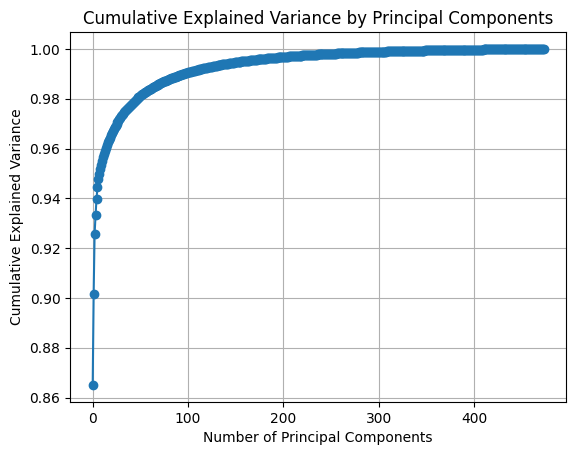

In [7]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [8]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components = p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
        Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
        )

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred= lda.predict(X_test)
    y_train_pred= lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))


In [9]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 52
Train Score for the best p: 0.93048128342246
Test Score for the best p: 0.92
Amélioration tu score de test: + 0.06


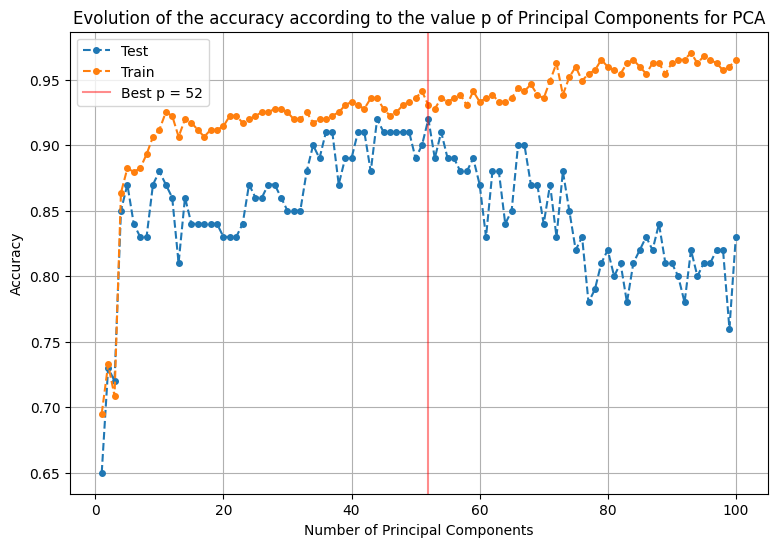

In [10]:
# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Train accuracy with the best p: 0.94
Train AUC with the best p: 0.98
Test accuracy with the best p: 0.91
Test auc with the best p: 0.96


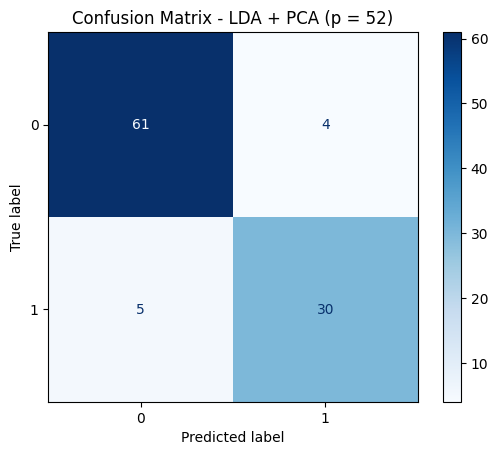

In [11]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

# Make predictions 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_test_pred = lda.predict(X_test)
y_train_pred = lda.predict(X_train)

# Compute the scores 
train_accuracy_LDA = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_LDA = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
print(f"Train accuracy with the best p: {train_accuracy_LDA:.2f}")
print(f"Train AUC with the best p: {roc_auc_score_train_LDA:.2f}")

test_accuracy_LDA = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_LDA = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_LDA:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_LDA:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - LDA + PCA (p = {best_p_value})")
plt.show()

## 2. Linear Regression, Ridge and Lasso

In this part, we explore the use of Ridge and Lasso Regressions for the classification task, as we want to perform regularization to prevent overfitting.

In [12]:
# We work with the orinial data and split it 
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    X, y, RANDOM_SPLIT=False, train_size=374
    )

X_train_cv, X_validation, y_train_cv, y_validation = useful_functions.split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300
    )

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (300, 64800)
Shape of y_train: (300,)
Shape of X_test: (74, 64800)
Shape of y_test: (74,)


### 2.1 Ridge Classification 

In [13]:
# Define and evaluate the Ridge classifier on the original training and test data
ridge = RidgeClassifier(alpha = 1.0)  # Default hyperparameter
ridge.fit(X_train, y_train)

print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {ridge.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {ridge.score(X_test, y_test):.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.850


c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.73634e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


In [14]:
# Hyperparameter tuning: Evaluate different lambda (regularization strength) values
lambda_values = np.logspace(1, 7, 100)

accuracy_train_cv_list = []
accuracy_valid_list = []
coefficients = []

for lambda_val in lambda_values:
    ridge = RidgeClassifier(alpha = lambda_val)
    ridge.fit(X_train_cv, y_train_cv)

    # Store accuracies for training and validation data
    accuracy_train_cv_list.append(ridge.score(X_train_cv, y_train_cv))
    accuracy_valid_list.append(ridge.score(X_validation, y_validation))

    # Store coefficients
    coefficients.append(ridge.coef_)

coefficients = np.array(coefficients)

# Find the lambda value that maximizes validation accuracy
max_accuracy_index = np.argmax(accuracy_valid_list)
max_lambda = lambda_values[max_accuracy_index]
max_accuracy = accuracy_valid_list[max_accuracy_index]
train_accuracy = accuracy_train_cv_list[max_accuracy_index]

print(f"Best lambda value after validation: {max_lambda:.1f}")
print(f"Accuracy for training: {train_accuracy:.3f}")
print(f"Accuracy for validation: {max_accuracy:.3f}")


Best lambda value after validation: 16297.5
Accuracy for training: 0.983
Accuracy for validation: 0.932


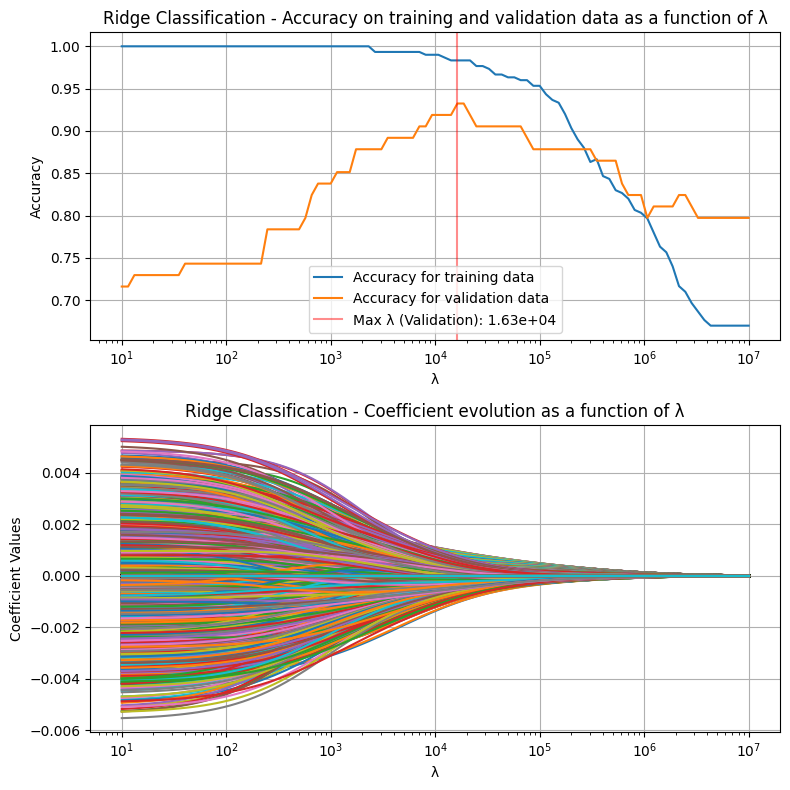

In [ ]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize = [8, 8])

# Plot accuracy for training and validation sets
plt.subplot(2, 1, 1)
plt.semilogx(lambda_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = max_lambda, color = 'r', linestyle = '-', label = f'Max λ (Validation): {max_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()

# Plot coefficient evolution
plt.subplot(2, 1, 2)
plt.semilogx(lambda_values, coefficients[:, 0])
plt.xlabel('λ')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Ridge Classification - Coefficient evolution as a function of λ')

plt.tight_layout()
plt.show()

Train accuracy with the best λ: 0.98
Train AUC with the best λ: 1.00
Test accuracy with the best λ: 0.91
Test AUC with the best λ: 0.96


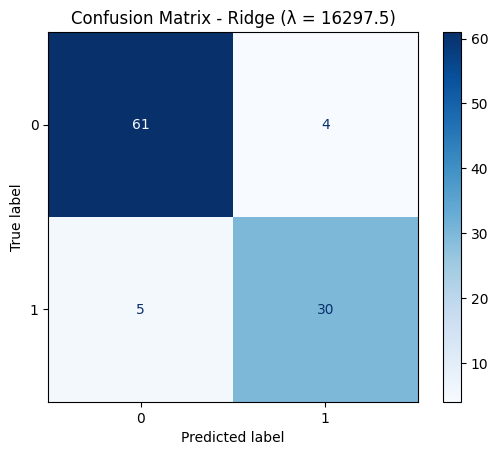

In [ ]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha = max_lambda)
ridge.fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

# Decision values for AUC computation
train_decision_values = ridge.decision_function(X_train)
test_decision_values = ridge.decision_function(X_test)

# Compute scores
train_accuracy_RIDGE = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_RIDGE = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy_RIDGE:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train_RIDGE:.2f}")

test_accuracy_RIDGE = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_RIDGE = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy_RIDGE:.2f}")
print(f"Test AUC with the best λ: {roc_auc_score_test_RIDGE:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ridge.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - Ridge (λ = {max_lambda:.1f})")
plt.show()

### 2.2 Lasso Classification

In this part, we will use the Lasso algorithm to perform a regularization of our model, trying to prevent overfitting. As there is no "LassoClassifier" function, we will use the LogisticRegression function with penalty parameter set to "l1".

In [17]:
# Define the classifier
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1.0) 
lasso.fit(X_train, y_train)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {lasso.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {lasso.score(X_test, y_test):.3f}")

==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.880


In [18]:
# Prepare the regularization parameter values
C_values = np.logspace(-3, 2, 50)

# Initialisation of the lists that will contain the accuracies and the coefficients
accuracy_train_cv_list = []
accuracy_valid_list = []
coefficients = []

for i in range(len(C_values)):
    # Define the classifier
    lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = C_values[i])
    lasso.fit(X_train_cv, y_train_cv)

    # Predict
    y_train_cv_pred = lasso.predict(X_train_cv)
    y_valid_pred = lasso.predict(X_validation)
    
    # Computation of the accuracy for train and validation
    accuracy_train_cv= lasso.score(X_train_cv, y_train_cv)
    accuracy_valid = lasso.score(X_validation, y_validation)

    # Add the values to the accuracy lists
    accuracy_train_cv_list.append(accuracy_train_cv)
    accuracy_valid_list.append(accuracy_valid)
    
    # Store the coefficients
    coefficients.append(lasso.coef_)
    
coefficients = np.array(coefficients)

# Find the C parameter that maximises the validation accuracy
max_accuracy_index = np.argmax(accuracy_valid_list)
max_C = C_values[max_accuracy_index]
max_accuracy = accuracy_valid_list[max_accuracy_index]
train_accuracy = accuracy_train_cv_list[max_accuracy_index]

print(f"Best lambda value after validation: {max_C:.1f}")
print(f"Accuracy for training: {train_accuracy:.3f}")
print(f"Accuracy for validation: {max_accuracy:.3f}")

Best lambda value after validation: 0.1
Accuracy for training: 0.933
Accuracy for validation: 0.932


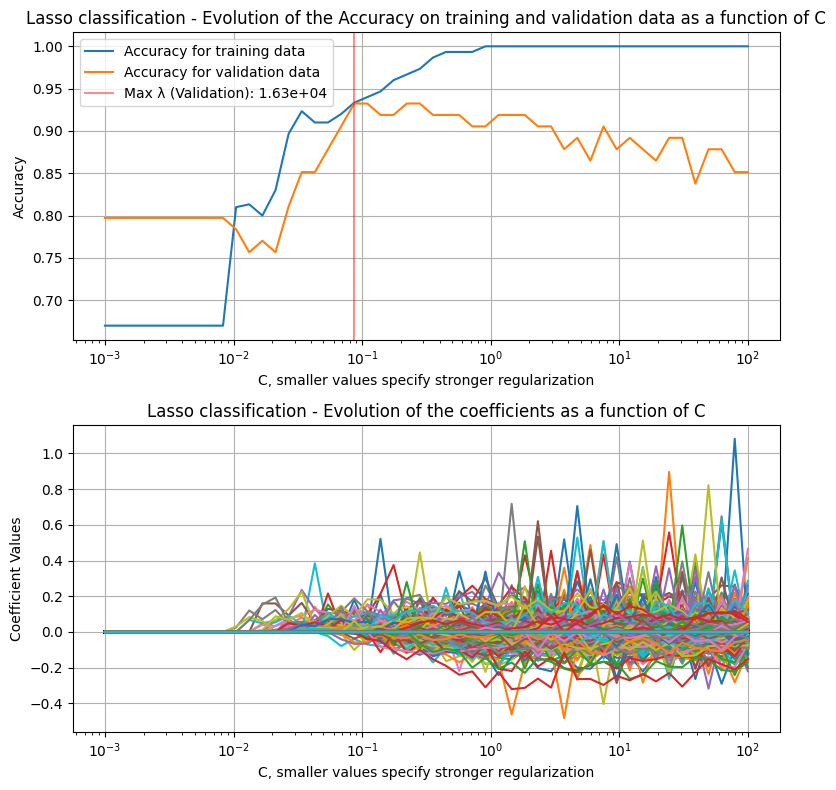

In [ ]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label = "Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label = "Accuracy for validation data")
plt.axvline(x = max_C, color = 'r', linestyle = '-', label = f'Max λ (Validation): {max_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

Train accuracy with the best λ: 0.94
Train AUC with the best λ: 0.98
Test accuracy with the best λ: 0.88
Test auc with the best λ: 0.97


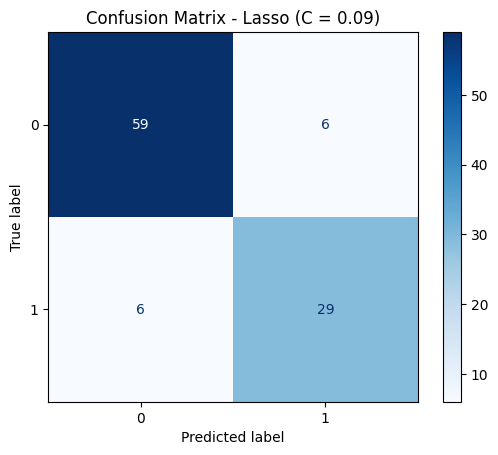

In [ ]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = max_C)
lasso.fit(X_train, y_train)

y_test_pred = lasso.predict(X_test)
y_train_pred = lasso.predict(X_train)

train_decision_values = lasso.decision_function(X_train)
test_decision_values = lasso.decision_function(X_test)

# Compute the scores 
train_accuracy_LASSO = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_LASSO = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy_LASSO:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train_LASSO:.2f}")

test_accuracy_LASSO = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_LASSO = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy_LASSO:.2f}")
print(f"Test auc with the best λ: {roc_auc_score_test_LASSO:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, lasso.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = lasso.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - Lasso (C = {max_C:.2f})")
plt.show()

## 3. Test Different Models

In this part, we want to do hyper-parameter tuning for different chosen models. However we have a lot of features and probably some of them are correlated which can prevent the models to perform properly. Here we perform a PCA, keeping 50 features, as the cumulative explained variance for 50 features is around 98% (see graph of the begining of the notebook). With this dimensionality reduction, we test the models to see which one is the better and then we select the best one and perform more precisely PCA, to see with which dimensions it performs the best.

In [21]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

In [22]:
# param grid for hyper-parameter tuning
qda_params = {'reg_param': [0, 0.1, 0.2, 0.5, 0.7, 0.9]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
param_grids = [qda_params, rf_params, svc_params, gb_params]

models = [QuadraticDiscriminantAnalysis(), RandomForestClassifier(), SVC(probability=True), GradientBoostingClassifier()]
model_names = ["QDA", "RandomForestClassifier", "SVC", "GradientBoostingClassifier"]

best_model_name = None
best_model = None
best_params = None
best_accuracy = 0
best_auc = 0

models_accuracies = []
models_auc = []

for i in range(len(models)):
    print(f"\nTuning {model_names[i]}")
    grid_search = GridSearchCV(models[i], param_grids[i], scoring = 'accuracy', cv = 5)
    grid_search.fit(X_train, y_train)

    # Best estimator and parameters
    best_estimator = grid_search.best_estimator_
    best_params_model = grid_search.best_params_
    best_accuracy_model = grid_search.best_score_

    # Evaluate on the test set
    y_test_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:, 1])

    print(f"Best Parameters for {model_names[i]}: {best_params_model}")
    print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

    models_accuracies.append(test_accuracy)
    models_auc.append(test_auc)

    if test_accuracy > best_accuracy or (test_accuracy == best_accuracy and test_auc > best_auc):
        best_model_name = model_names[i]
        best_model = best_estimator
        best_params = best_params_model
        best_accuracy = test_accuracy
        best_auc = test_auc

print(f"\nBest Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best AUC: {best_auc:.4f}")


Tuning QDA
Best Parameters for QDA: {'reg_param': 0.9}
Test Accuracy: 0.8300, Test AUC: 0.9341

Tuning RandomForestClassifier
Best Parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 200}
Test Accuracy: 0.8600, Test AUC: 0.9127

Tuning SVC
Best Parameters for SVC: {'C': 1, 'kernel': 'linear'}
Test Accuracy: 0.8400, Test AUC: 0.9481

Tuning GradientBoostingClassifier
Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Test Accuracy: 0.8900, Test AUC: 0.9411

Best Model: GradientBoostingClassifier
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Accuracy: 0.8900
Best AUC: 0.9411


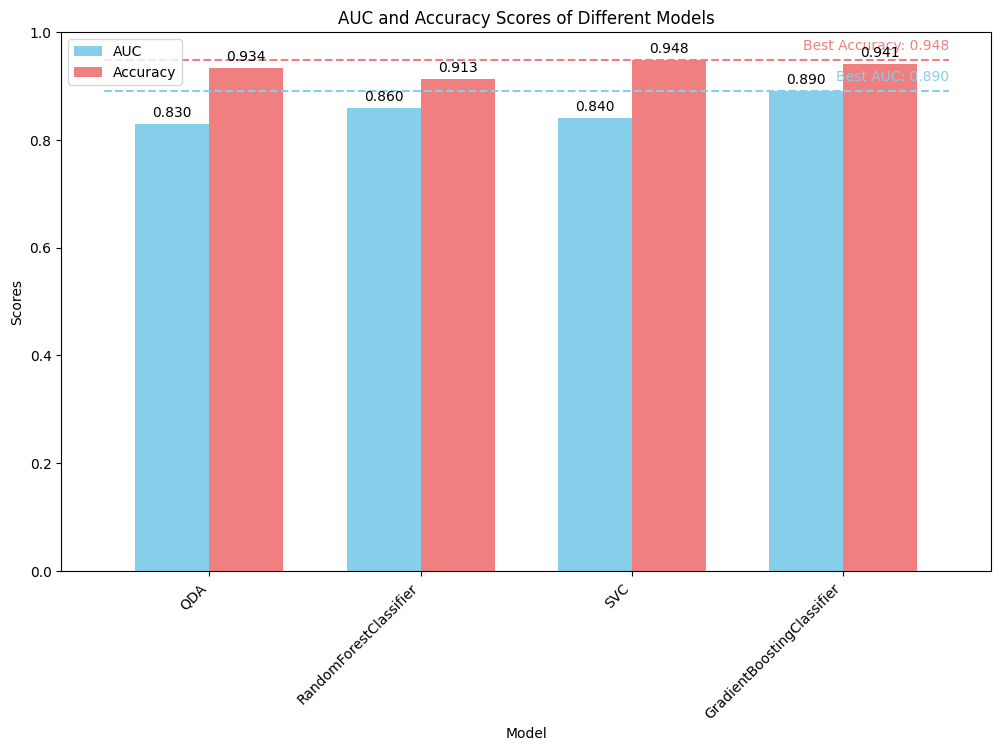

In [23]:
def plot_score(model_names, auc_scores, accuracy_scores):
    x = np.arange(len(model_names))
    fig, ax = plt.subplots(figsize = (12, 7))

    #plot the histograms of accuracy and auc 
    auc_bars = ax.bar(x - 0.175, auc_scores, 0.35, label = 'AUC', color = 'skyblue')
    accuracy_bars = ax.bar(x + 0.175, accuracy_scores, 0.35, label = 'Accuracy', color = 'lightcoral')

    #plot horizontal lines for the highest accuracy and auc
    max_auc = max(auc_scores)
    max_accuracy = max(accuracy_scores)
    ax.hlines(y = max_auc, xmin = -0.5, xmax = len(model_names)-0.5, colors = 'skyblue', linestyles = '--', linewidth = 1.5) 
    ax.hlines(y = max_accuracy, xmin = -0.5, xmax = len(model_names)-0.5, colors = 'lightcoral', linestyles = '--', linewidth = 1.5)  
    ax.text(len(model_names)-0.5, max_auc + 0.02, f'Best AUC: {max_auc:.3f}', color='skyblue', ha='right')
    ax.text(len(model_names)-0.5, max_accuracy + 0.02, f'Best Accuracy: {max_accuracy:.3f}', color='lightcoral', ha='right')

    ax.set_xlabel('Model')
    ax.set_ylabel('Scores')
    ax.set_ylim(0, 1)
    ax.set_title('AUC and Accuracy Scores of Different Models')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation = 45, ha = 'right')
    ax.set_xticklabels(model_names)
    ax.legend()

    #annotations for the value of each bar
    for bar in auc_bars + accuracy_bars:
        ax.annotate(f'{bar.get_height():.3f}', 
                    xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    xytext = (0, 3), 
                    textcoords = "offset points",
                    ha = 'center', va = 'bottom')

    plt.show()

plot_score(model_names, models_accuracies, models_auc)

### Test the Best Model 

In [24]:
p_values = np.linspace(1, 50, 50).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    PCA_sst = PCA(n_components = p)
    PCA_sst.fit(X)

    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    model = best_model

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)

In [25]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")

Best value of p - PCA : 13
Train Score for the best p: 1.0
Test Score for the best p: 0.91


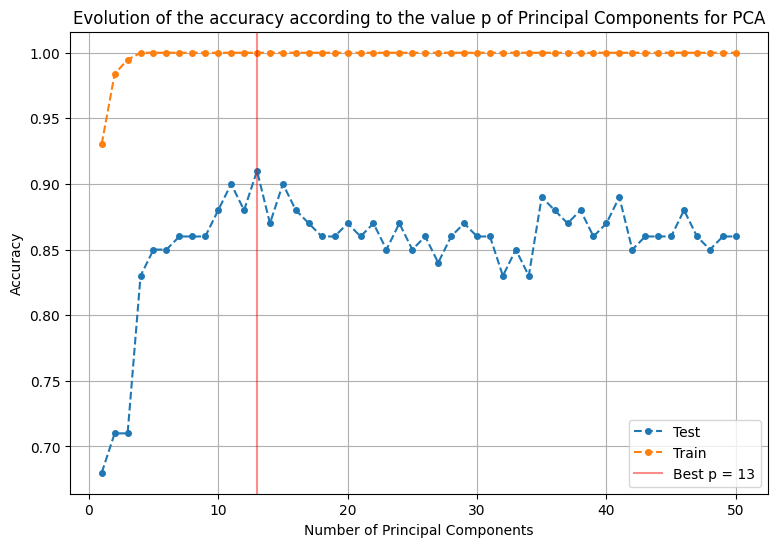

In [26]:
# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize = 4, ls = '--', label = "Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize = 4, ls = '--', label = "Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 1.00
Test auc with the best p: 1.00
Test accuracy with the best p: 0.87
Test auc with the best p: 0.93


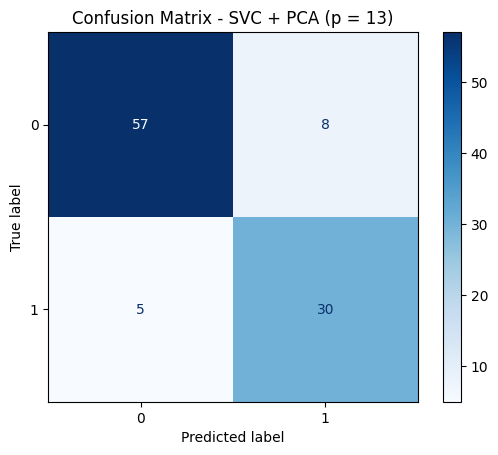

In [ ]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)
y_train_pred = best_model_pca.predict(X_train)

# Print the scores
train_accuracy_SVC = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_SVC = roc_auc_score(y_train, best_model_pca.predict_proba(X_train)[:, 1])
print(f"Test accuracy with the best p: {train_accuracy_SVC:.2f}")
print(f"Test auc with the best p: {roc_auc_score_train_SVC:.2f}")

test_accuracy_SVC = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_SVC = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_SVC:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_SVC:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = best_model_pca.classes_)
disp.plot(cmap = 'Blues')
plt.title(f"Confusion Matrix - SVC + PCA (p = {best_p_value})")
plt.show()

## 4) Neural Networks 

Let's try to use Neural Networks for now. We won't be doing like the part 3 because the Pipeline() method is taking a lot of time and computations. We are going to project the data on 50 features as the cumulative explained variance is around 98% for 50 features (see the figure we plotted above -- we won't loose a lot of information) and then we will select the best model and tune the best p for the PCA.

In [29]:
# Define PCA for 50 features 
PCA_sst = PCA(n_components = 50)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
    )

In [ ]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              
        (128, 64),           
        (128, 64, 32),       
        (256, 128, 64),      
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  
    'solver': ['adam'],           
    'max_iter': [200],            
}

mlp = MLPClassifier(random_state = 42, early_stopping = True, validation_fraction = 0.2)

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
grid_search = GridSearchCV(estimator=mlp, param_grid = param_grid, scoring = 'accuracy', cv = cv)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")

Best parameters found: {'alpha': 0.01, 'hidden_layer_sizes': (256, 128, 64), 'max_iter': 200, 'solver': 'adam'}
Best cross-validated accuracy: 0.901


In [31]:
# Validation curve with different values of p for the MLP model
p_values = np.linspace(1, 50, 50).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
        Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
        )

    # Define the classifier
    model = grid_search.best_estimator_

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred= model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)


In [32]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")

Best value of p - PCA : 5
Train Score for the best p: 0.8983957219251337
Test Score for the best p: 0.89


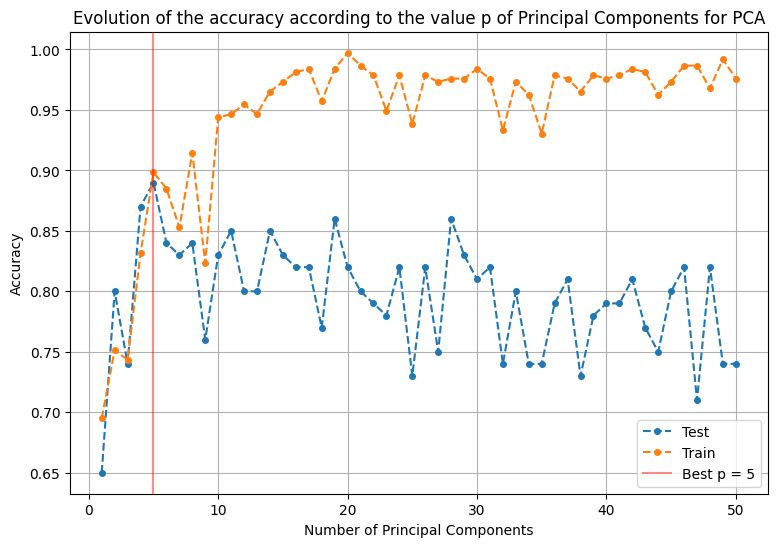

In [33]:
# Plot the validation curve
plt.figure(figsize = [9,6])
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.90
Test auc with the best p: 0.96
Test accuracy with the best p: 0.89
Test auc with the best p: 0.95


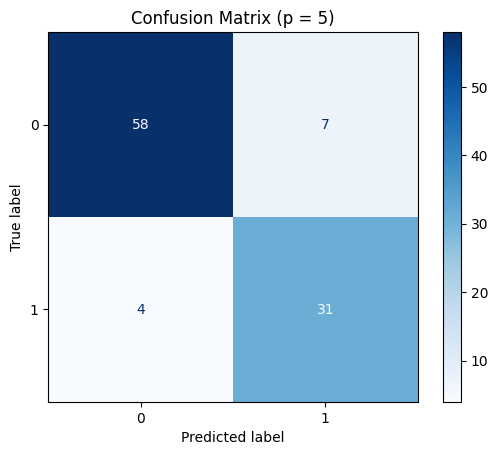

In [35]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)
y_train_pred = best_model_pca.predict(X_train)

# Print the scores
train_accuracy_MLP = accuracy_score(y_train, y_train_pred)
roc_auc_score_train_MLP = roc_auc_score(y_train, best_model_pca.predict_proba(X_train)[:, 1])
print(f"Test accuracy with the best p: {train_accuracy_MLP:.2f}")
print(f"Test auc with the best p: {roc_auc_score_train_MLP:.2f}")

# Print the scores
test_accuracy_MLP = accuracy_score(y_test, y_test_pred)
roc_auc_score_test_MLP = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy_MLP:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test_MLP:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = best_model_pca.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

## 5)Recap of the Models

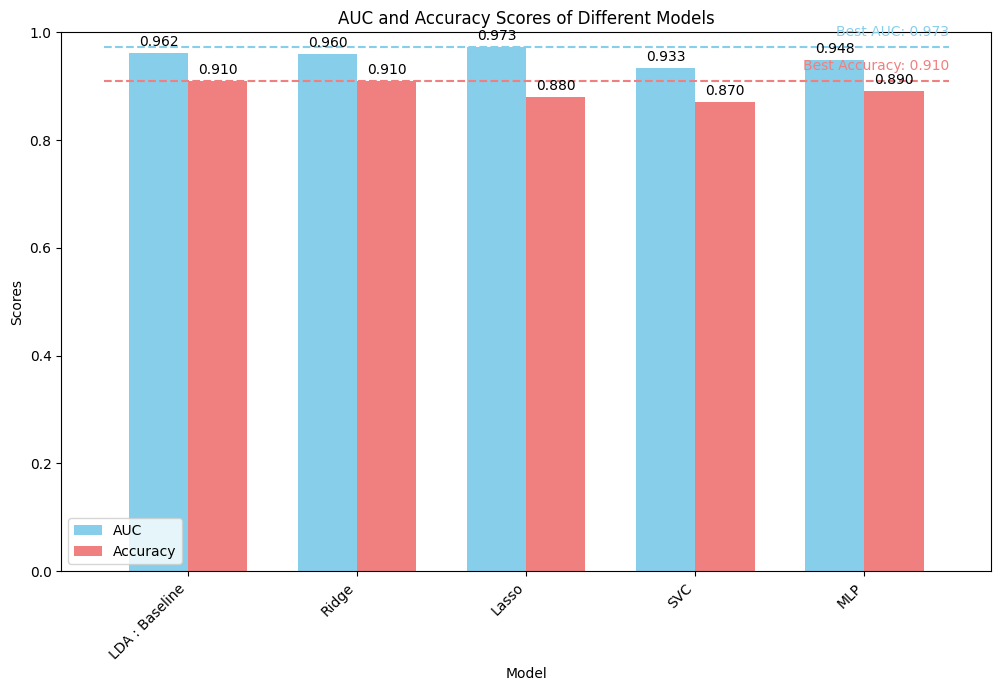

In [37]:
model_names = ["LDA : Baseline", "Ridge", "Lasso", "SVC", "MLP"]
models_accuracies = [test_accuracy_LDA, test_accuracy_RIDGE, test_accuracy_LASSO, test_accuracy_SVC, test_accuracy_MLP]
models_auc = [roc_auc_score_test_LDA, roc_auc_score_test_RIDGE, roc_auc_score_test_LASSO, roc_auc_score_test_SVC, roc_auc_score_test_MLP]
plot_score(model_names, models_auc, models_accuracies)